## Main analysis for Capstone

Importing all libraries first

In [1]:
# For Google Colab, have to run this every time at startup
!pip install lifelines

     |████████████████████████████████| 419kB 46.8MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections

import warnings
warnings.filterwarnings("ignore")
import joblib

from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.weightstats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from sklearn.cluster import KMeans, OPTICS

from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.pipeline import Pipeline as imPipeline

#import tensorflow as tf

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

from sklearn.mixture import GaussianMixture

First load the source csv file into `pandas`:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# To load the csv file from my local computer
df_grand = pd.read_csv('NSCLC-Radiomics-agg-padded.csv')

Define some boolean variables based on whether the patient has died (`deadstatus.event`==1) and the registered survival time of the patient. For this study, we look at the patients at 1-year, 3-year, and 5-year marks.

In [3]:
dead = df_grand['deadstatus.event'].astype(bool)

mask_1yr = (df_grand['Survival.time'] >= 365)
mask_3yr = (df_grand['Survival.time'] >= 3*365)
mask_5yr = (df_grand['Survival.time'] >= 5*365)

In [4]:
df_tf = df_grand.copy()

Transforming data based on EDA:

In [5]:
# Originally, define a small epsilon such that features can be log-transformed after zero-padding
# All tumours have since been aggregated, so zero-padding is no longer necessary
eps = 0

for i in range(1):
    str_i = str(i)
    
    # Shape
    df_tf.drop(columns=['shape_VoxelVolume_'+str_i, 
                        'shape_Maximum2DDiameterColumn_'+str_i, 
                        'shape_Maximum2DDiameterRow_'+str_i], inplace=True)
    
    df_tf['log_shape_MeshVolume_'+str_i] = np.log( df_tf['shape_MeshVolume_'+str_i] + eps )
    df_tf.drop(columns=['shape_MeshVolume_' + str_i])
    
    # GLDM
    df_tf.drop(columns=['gldm_LargeDependenceEmphasis_'+str_i], 
               inplace = True)
    
    df_tf['log_gldm_GrayLevelVariance_' + str_i] = np.log(df_tf['gldm_GrayLevelVariance_' + str_i] + eps)
    df_tf['log_gldm_DependenceNonUniformity_' + str_i] = np.log(df_tf['gldm_DependenceNonUniformity_' + str_i] + eps)
    df_tf['log_gldm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['gldm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['bc_gldm_LargeDependenceLowGrayLevelEmphasis_' 
          + str_i] = boxcox(df_tf['gldm_LargeDependenceLowGrayLevelEmphasis_' + str_i] + eps)[0]
    df_tf['bc_gldm_SmallDependenceLowGrayLevelEmphasis_' 
          + str_i] = boxcox(df_tf['gldm_SmallDependenceLowGrayLevelEmphasis_' + str_i] + eps)[0]
    df_tf['bc_gldm_LowGrayLevelEmphasis_' + str_i] = boxcox(df_tf['gldm_LowGrayLevelEmphasis_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['gldm_GrayLevelVariance_' + str_i,
                        'gldm_DependenceNonUniformity_' + str_i,
                        'gldm_GrayLevelNonUniformity_' + str_i,
                        'gldm_LargeDependenceLowGrayLevelEmphasis_' + str_i,
                        'gldm_SmallDependenceLowGrayLevelEmphasis_' + str_i,
                        'gldm_LowGrayLevelEmphasis_' + str_i], inplace=True)
    
    # GLCM
    df_tf.drop(columns=['glcm_SumAverage_' + str_i, 
                        'glcm_JointAverage_' + str_i,
                        'glcm_SumEntropy_' + str_i,
                        'glcm_DifferenceEntropy_' + str_i,
                        'glcm_Id_' + str_i,
                        'glcm_Idn_' + str_i,
                        'glcm_ClusterTendency_' + str_i,
                        'glcm_Contrast_' + str_i], inplace=True)
    df_tf['bc_glcm_JointEnergy_' + str_i] = boxcox(df_tf['glcm_JointEnergy_' + str_i] + eps)[0]
    df_tf['log_glcm_DifferenceVariance_' + str_i] = np.log(df_tf['glcm_DifferenceVariance_' + str_i] + eps)
    df_tf['log_glcm_SumSquares_' + str_i] = np.log(df_tf['glcm_SumSquares_' + str_i] + eps)
    df_tf['bc_glcm_ClusterProminence_' + str_i] = boxcox(df_tf['glcm_ClusterProminence_' + str_i] + eps)[0]
    df_tf['bc_glcm_DifferenceAverage_' + str_i] = boxcox(df_tf['glcm_DifferenceAverage_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['glcm_JointEnergy_' + str_i,
                        'glcm_DifferenceVariance_' + str_i,
                        'glcm_SumSquares_' + str_i,
                        'glcm_ClusterProminence_' + str_i,
                        'glcm_DifferenceAverage_' + str_i], inplace=True)
    
    # First order
    df_tf.drop(columns=['firstorder_RobustMeanAbsoluteDeviation_' + str_i, 
                        'firstorder_MeanAbsoluteDeviation_' + str_i,
                        'firstorder_TotalEnergy_' + str_i], inplace=True)
    df_tf['bc_firstorder_InterquartileRange_' + str_i] = boxcox(df_tf['firstorder_InterquartileRange_' + str_i] + eps)[0]
    df_tf['log_firstorder_Energy_' + str_i] = np.log(df_tf['firstorder_Energy_' + str_i] + eps)
    df_tf['log_firstorder_Kurtosis_' + str_i] = np.log(df_tf['firstorder_Kurtosis_' + str_i] + eps)
    df_tf['log_firstorder_RootMeanSquared_' + str_i] = np.log(df_tf['firstorder_RootMeanSquared_' + str_i] + eps)
    
    # GLRLM
    df_tf.drop(columns=['glrlm_ShortRunLowGrayLevelEmphasis_' + str_i,
                        'glrlm_LowGrayLevelRunEmphasis_' + str_i,
                        'glrlm_LongRunEmphasis_' + str_i,
                        'glrlm_RunLengthNonUniformityNormalized_' + str_i,
                        'glrlm_ShortRunEmphasis_' + str_i], inplace=True)
    df_tf['log_glrlm_GrayLevelVariance_' + str_i] = np.log(df_tf['glrlm_GrayLevelVariance_' + str_i] + eps)
    df_tf['log_glrlm_RunVariance_' + str_i] = np.log(df_tf['glrlm_RunVariance_' + str_i] + eps)
    df_tf['log_glrlm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['glrlm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['log_glrlm_RunLengthNonUniformity_' + str_i] = np.log(df_tf['glrlm_RunLengthNonUniformity_' + str_i] + eps)
    df_tf['bc_glrlm_LongRunLowGrayLevelEmphasis_' + str_i] = boxcox(df_tf['glrlm_LongRunLowGrayLevelEmphasis_' 
                                                                          + str_i] + eps)[0]
    
    df_tf.drop(columns=['glrlm_GrayLevelVariance_' + str_i,
                        'glrlm_RunVariance_' + str_i,
                        'glrlm_GrayLevelNonUniformity_' + str_i,
                        'glrlm_RunLengthNonUniformity_' + str_i,
                        'glrlm_LongRunLowGrayLevelEmphasis_' + str_i], inplace = True)
    
    # GLSZM
    df_tf.drop(columns=['glszm_LargeAreaEmphasis_' + str_i,
                        'glszm_LargeAreaHighGrayLevelEmphasis_' + str_i,
                        'glszm_SmallAreaEmphasis_' + str_i,
                        'glszm_SmallAreaHighGrayLevelEmphasis_' + str_i,
                        'glszm_SmallAreaLowGrayLevelEmphasis_' + str_i], inplace=True)
    df_tf['log_glszm_GrayLevelVariance_' + str_i] = boxcox(df_tf['glszm_GrayLevelVariance_' + str_i] + eps)[0]
    df_tf['bc_glszm_ZoneVariance_' + str_i] = boxcox(df_tf['glszm_ZoneVariance_' + str_i] + eps)[0]
    df_tf['log_glszm_GrayLevelNonUniformityNormalized_' + str_i] = np.log(df_tf['glszm_GrayLevelNonUniformityNormalized_' 
                                                                                + str_i] + eps)
    df_tf['log_glszm_SizeZoneNonUniformity_' + str_i] = np.log(df_tf['glszm_SizeZoneNonUniformity_' + str_i] + eps)
    df_tf['log_glszm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['glszm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['log_glszm_ZonePercentage_' + str_i] = np.log(df_tf['glszm_ZonePercentage_' + str_i] + eps)
    df_tf['log_glszm_LargeAreaLowGrayLevelEmphasis_' + str_i] = np.log(df_tf['glszm_LargeAreaLowGrayLevelEmphasis_' 
                                                                             + str_i] + eps)
    df_tf['bc_glszm_LowGrayLevelZoneEmphasis_' + str_i] = boxcox(df_grand['glszm_LowGrayLevelZoneEmphasis_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['glszm_GrayLevelVariance_' + str_i,
                        'glszm_ZoneVariance_' + str_i,
                        'glszm_GrayLevelNonUniformityNormalized_' + str_i,
                        'glszm_SizeZoneNonUniformity_' + str_i,
                        'glszm_GrayLevelNonUniformity_' + str_i,
                        'glszm_ZonePercentage_' + str_i,
                        'glszm_LargeAreaLowGrayLevelEmphasis_' + str_i,
                        'glszm_LowGrayLevelZoneEmphasis_' + str_i], inplace=True)

How many features are left? And which columns are the features?

In [6]:
# Number of features at the end
num_feat = len(df_tf.columns[df_tf.columns.str.contains('_0')])

In [7]:
feat_mask = df_tf.columns.str.contains('_0')

---
### 1-year analysis:

We look at patients satisfying one of the two following criteria:
- The patient has passed away, and his/ her survival time is definite; OR
- The patient has survived past the 1-year mark regardless whether the patient has passed away

In [12]:
X1 = df_tf[mask_1yr | dead][df_tf.columns[feat_mask]]
y1 = (df_tf[mask_1yr | dead]['Survival.time']> 365).astype(int)

In [13]:
X1 = X1.astype(float)

Looking at the total number of patients being studied here:

In [10]:
y1.shape

(418,)

Split the data into training set and test set:

In [14]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)

Look at the class imbalance:

In [ ]:
y1_train.value_counts()

1    190
0    102
Name: Survival.time, dtype: int64

Hence there are 190 patients in the training set who have survived for more than 1 year, and 102 who have not.

We scale all features in the training set such that all features centred at zero and have variances of 1. The test set is also scaled, BUT with the scaling factors determined from the training set:

In [15]:
my_scaler = StandardScaler()
X1_train = my_scaler.fit_transform(X1_train)
X1_test = my_scaler.transform(X1_test)

Then run through various models:

#### Logistic Regression

In [ ]:
my_logit = LogisticRegression()
my_logit.fit(X1_train, y1_train)
my_logit.score(X1_train, y1_train)

0.7705479452054794

The test accuracy for the logistic regression model is:

In [ ]:
my_logit.score(X1_test, y1_test)

0.6111111111111112

To further optimize the results, run a grid search:
- Try LASSO (i.e. `penalty='l1'`) and Ridge regression (i.e. `penalty='l2'`)
- Try different normalization strengths (for C, the inverse of the normalization strengths, ranging from $10^{-6}$ to $10^6$)

In [ ]:
estimators = [('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'logreg_1yr.pkl')

['logreg_1yr.pkl']

The optimized hyperparameters are:

In [ ]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

The score on the training set is:

In [ ]:
fittedgrid.score(X1_train, y1_train)

0.7328767123287672

While the score on the test set is:

In [ ]:
fittedgrid.score(X1_test, y1_test)

0.626984126984127

Plot some graphs! Define some lists first, then write into a dataframe:

In [ ]:
logit_grid_C = fittedgrid.cv_results_['param_model__C'].data

logit_grid_penalty =fittedgrid.cv_results_['param_model__penalty'].data

logit_grid_score = fittedgrid.cv_results_['mean_test_score']

In [ ]:
df_logit = pd.DataFrame({'C': logit_grid_C,
                         'penalty': logit_grid_penalty,
                         'score': logit_grid_score})
df_logit.head()

,C,penalty,score
0,1e-06,l1,0.650731
1,1e-06,l2,0.650731
2,1e-05,l1,0.650731
3,1e-05,l2,0.650731
4,0.0001,l1,0.650731


This graph is for the function of validation score as a function fo the regularization parameter for both L1 and L2 regularization:

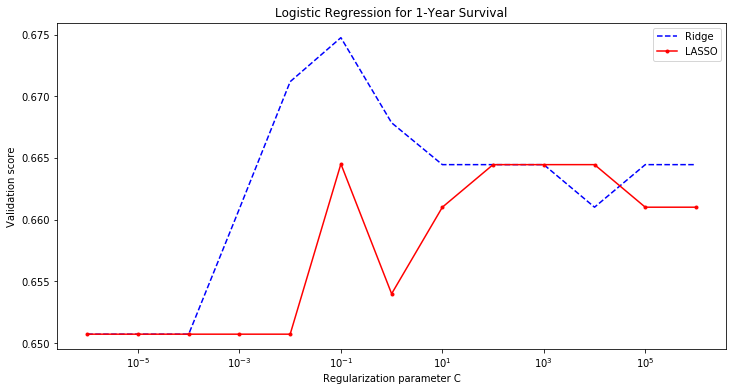

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_logit[df_logit['penalty']=='l2']['C'], df_logit[df_logit['penalty']=='l2']['score'], 'b--', label='Ridge')
plt.plot(df_logit[df_logit['penalty']=='l1']['C'], df_logit[df_logit['penalty']=='l1']['score'], 'r.-', label='LASSO')
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

Since the accuracy score is so low, and there is a slight imbalance in the classes, let us print out the f1-score and the confusion matrix also for the test set:

In [ ]:
y_pred_logit = fittedgrid.predict(X1_test)
print(classification_report(y1_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



Repeat the logistic regression with principal component analysis:

In [ ]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [LogisticRegression(solver='saga')], 
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid_pca = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'logreg_pca_1yr.pkl')

['logreg_pca_1yr.pkl']

In [ ]:
fittedgrid_pca.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=45,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

What is the optimal number of principal components to be included in the analysis?

In [ ]:
fittedgrid_pca.best_params_['pca__n_components']

45

In [ ]:
fittedgrid_pca.score(X1_train, y1_train)

0.7328767123287672

In [ ]:
fittedgrid_pca.score(X1_test, y1_test)

0.626984126984127

In [ ]:
y_pred_logit_pca = fittedgrid_pca.predict(X1_test)
print(classification_report(y1_test, y_pred_logit_pca))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



Now define some more lists for the plot of the accuracy scores as a function of the hyperparameters:

In [ ]:
logit_pca_grid_C = fittedgrid_pca.cv_results_['param_model__C'].data

logit_pca_grid_penalty =fittedgrid_pca.cv_results_['param_model__penalty'].data

logit_pca_grid_score = fittedgrid_pca.cv_results_['mean_test_score']

logit_pca_grid_n_components = fittedgrid_pca.cv_results_['param_pca__n_components'].data

In [ ]:
df_logit_pca = pd.DataFrame({'C': logit_pca_grid_C,
                             'penalty': logit_pca_grid_penalty,
                             'n_components': logit_pca_grid_n_components,
                             'score': logit_pca_grid_score})
df_logit_pca.head()

,C,penalty,n_components,score
0,1e-06,l1,5,0.650731
1,1e-06,l1,10,0.650731
2,1e-06,l1,15,0.650731
3,1e-06,l1,20,0.650731
4,1e-06,l1,25,0.650731


First, a plot of accuracy as a function of the regularization parameter for both Ridge and LASSO:

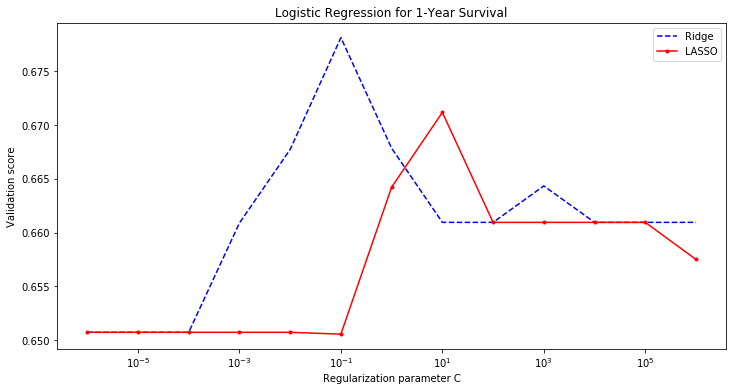

In [ ]:
n_PCA = fittedgrid_pca.best_params_['pca__n_components']

plt.figure(figsize=(12,6))
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['n_components']==n_PCA)]['C'], 
         df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['n_components']==n_PCA)]['score'], 'b--', label='Ridge')
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['n_components']==n_PCA)]['C'], 
         df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['n_components']==n_PCA)]['score'], 'r.-', label='LASSO')
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

Then accuracy score as a function of number of principal components used:

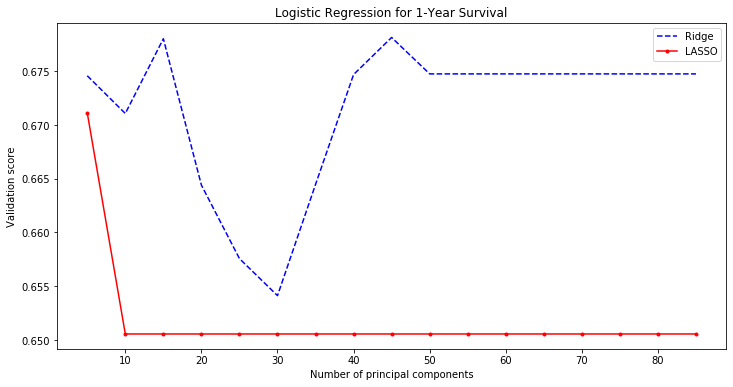

In [ ]:
best_C = fittedgrid_pca.best_params_['model__C']

plt.figure(figsize=(12,6))
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['C']==best_C)]['n_components'], 
         df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['C']==best_C)]['score'], 'b--', label='Ridge')
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['C']==best_C)]['n_components'], 
         df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['C']==best_C)]['score'], 'r.-', label='LASSO')
plt.xlabel('Number of principal components')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

It is interesting that for LASSO, using more than 5 principal components will not make a difference in the accuracy score. That may be because the regularization forces the coefficients in front of the other principal components to be zero anyway.

In [ ]:
fittedgrid_pca.score(X1_train, y1_train)

0.7328767123287672

In [ ]:
fittedgrid_pca.score(X1_test, y1_test)

0.626984126984127

Let's see the confusion matrix:

In [ ]:
y1_pred_pca = fittedgrid_pca.predict(X1_test)
print(classification_report(y1_test, y1_pred_pca))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



#### Decision Tree

Run a grid search to optimize the hyperparameter for a decision tree.  The hyperparameters to be tuned are:
- number of principal components used
- maximum depth of the decision tree
- minimum number of sample points on a leaf

In [ ]:
estimators = [('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [DecisionTreeClassifier()],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)],
               'pca__n_components': [x for x in range(5,num_feat,5)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'dt_pca_1yr.pkl')

['dt_pca_1yr.pkl']

In [ ]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [ ]:
fittedgrid.best_score_

0.6573348918760958

Then the score on the entire training set and on the test set:

In [ ]:
fittedgrid.score(X1_train, y1_train)

0.7705479452054794

In [ ]:
fittedgrid.score(X1_test, y1_test)

0.6984126984126984

#### Random Forest

I will use grid search again to optimize the hyperparameter for my random forest model.
The hyperparameters to be optimized are:
- number of principal components
- maximum depth of each tree in the random forest
- minimum number of samples in a leaf in the random forest
- number of estimators in a random forest

In [ ]:
estimators = [('pca', PCA()),
              ('model', RandomForestClassifier(n_jobs=-1))]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [RandomForestClassifier(n_jobs=-1)],
               'model__n_estimators': [i for i in range(10,110,10)],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)],
               'pca__n_components': [x for x in range(5,num_feat,5)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

In [ ]:
joblib.dump(fittedgrid, 'rf_pca_1yr.pkl')

In [9]:
fittedgrid.best_score_

0.6986301369863014

In [10]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=70,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=30, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_

What is the score of the best random forest score on the entire training set?

In [ ]:
fittedgrid.score(X1_train, y1_train)

0.7705479452054794

And the accuracy score on the test set?

In [ ]:
fittedgrid.score(X1_test, y1_test)

0.6349206349206349

And the classification report stating the precision and the recall:

In [16]:
print(classification_report(y1_test, fittedgrid.predict(X1_test)))

              precision    recall  f1-score   support

           0       0.50      0.09      0.15        46
           1       0.64      0.95      0.77        80

    accuracy                           0.63       126
   macro avg       0.57      0.52      0.46       126
weighted avg       0.59      0.63      0.54       126



#### XGBoost decision tree

The hyperparameters to be optimized for the XGBoost decision tree are:
- number of principal components
- maximum depth of the tree
- number of estimators in the model

In [ ]:
estimators = [('pca', PCA()),
              ('model', XGBClassifier(n_jobs=-1))]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [XGBClassifier(n_jobs=-1)], 
               'model__max_depth': [i for i in range(1,11)],
               'model__n_estimators': [i for i in range(10,160,10)]}]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'xgb_pca_1yr.pkl')

['xgb_pca_1yr.pkl']

In [ ]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=75,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=30, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [ ]:
fittedgrid.best_score_

0.6850964348334307

The accuracy score on the entire training set is:

In [ ]:
fittedgrid.score(X1_train, y1_train)

0.934931506849315

The accuracy score on the test set is:

In [ ]:
fittedgrid.score(X1_test, y1_test)

0.626984126984127

Plot the accuracy score as a function of the hyperparameters:

In [ ]:
xgb_grid_maxdepth = fittedgrid.cv_results_['param_model__max_depth'].data
xgb_grid_n_estimators = fittedgrid.cv_results_['param_model__n_estimators'].data
xgb_grid_n_components = fittedgrid.cv_results_['param_pca__n_components'].data
xgb_grid_score = fittedgrid.cv_results_['mean_test_score']

In [ ]:
df_xgb = pd.DataFrame({'max_depth': xgb_grid_maxdepth,
                       'n_estimators': xgb_grid_n_estimators,
                       'n_components': xgb_grid_n_components,
                       'score': xgb_grid_score})

First, plot the accuracy (validation score) as a function of the number of maximum depth of the estimator:

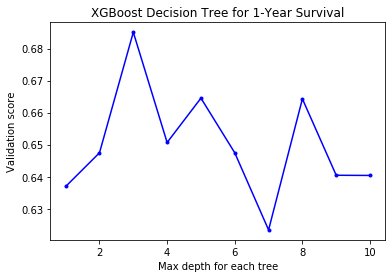

In [ ]:
xgb_n_est = fittedgrid.best_params_['model__n_estimators']
xgb_n_comp = fittedgrid.best_params_['pca__n_components']

plt.figure()
plt.plot(df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['n_components']==xgb_n_comp)]['max_depth'], 
         df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['n_components']==xgb_n_comp)]['score'], 'b.-')
plt.xlabel('Max depth for each tree')
plt.ylabel('Validation score')
plt.title('XGBoost Decision Tree for 1-Year Survival')
plt.show()

And then plot the validation score as a function of the number of princiapl components used in the model:

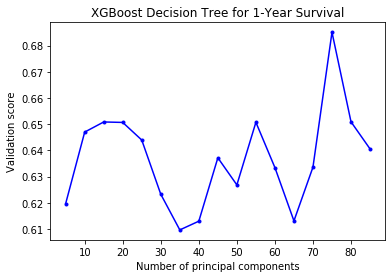

In [ ]:
xgb_max_depth = fittedgrid.best_params_['model__max_depth']

plt.figure()
plt.plot(df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['max_depth']==xgb_max_depth)]['n_components'], 
         df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['max_depth']==xgb_max_depth)]['score'], 'b.-')
plt.xlabel('Number of principal components')
plt.ylabel('Validation score')
plt.title('XGBoost Decision Tree for 1-Year Survival')
plt.show()

The classification report is:

In [19]:
fittedgrid = joblib.load('Pickle files/1 year/xgb_pca_1yr.pkl')

In [20]:
print(classification_report(y1_test, fittedgrid.predict(X1_test)))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



#### Support Vector Machine

The hyperparameters being optimized for the support vector machines are:
- the number of princiapl components used
- the regularization parameter (ranging from $10^-6$ to $10^7$)
- the kernel for the support vector classifier

In [ ]:
estimators = [('pca', PCA()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'svm_pca_1yr.pkl')

['svm_pca_1yr.pkl']

In [ ]:
fittedgrid.best_params_

{'model': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='poly',
     max_iter=999, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'model__C': 10,
 'model__kernel': 'poly',
 'pca': PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'pca__n_components': 5}

In [ ]:
fittedgrid.best_score_

0.6952074810052601

The accuracy score of the SVM with the test set is:

In [ ]:
fittedgrid.score(X1_test, y1_test)

0.6507936507936508

The classification report is as follows:

In [22]:
fittedgrid = joblib.load('Pickle files/1 year/svm_pca_1yr.pkl')

In [23]:
print(classification_report(y1_test, fittedgrid.predict(X1_test)))

              precision    recall  f1-score   support

           0       0.57      0.17      0.27        46
           1       0.66      0.93      0.77        80

    accuracy                           0.65       126
   macro avg       0.62      0.55      0.52       126
weighted avg       0.63      0.65      0.59       126



The confusion matrix is:

In [24]:
print(confusion_matrix(y1_test, fittedgrid.predict(X1_test)))

[[ 8 38]
 [ 6 74]]


Not great

#### Quadratic Discriminant Analysis

There are no hyperparameters to tune for the quadratic discriminant analysis:

In [ ]:
my_qda = QuadraticDiscriminantAnalysis()
my_qda.fit(X1_train, y1_train)
joblib.dump(my_qda, 'qda_1yr.pkl')

['qda_1yr.pkl']

In [ ]:
my_qda.score(X1_train, y1_train)

1.0

That might have been how the math has to work out for the quadratic discriminant analysis?
As for the accuracy score with the test set:

In [ ]:
my_qda.score(X1_test, y1_test)

0.6666666666666666

In [25]:
my_qda = joblib.load('Pickle files/1 year/qda_1yr.pkl')

In [26]:
print(classification_report(y1_test, my_qda.predict(X1_test)))

              precision    recall  f1-score   support

           0       0.83      0.11      0.19        46
           1       0.66      0.99      0.79        80

    accuracy                           0.67       126
   macro avg       0.75      0.55      0.49       126
weighted avg       0.72      0.67      0.57       126



Surprisingly, the recall for the quadratic discriminant is the highest. That means a patient surviving past the 1-year mark is most likely to be correctly identified with the quadratic discriminant analysis.


#### Neural network

For the neural network model, I will use the TensorFlow library.

The input size is the number of features, and the output size is 2, the number of classes (patients surviving past the 1-year mark, and those who do not)

In [ ]:
input_size = num_feat
output_size = 2

In [ ]:
# Make the placeholder variables:
input_X = tf.placeholder(tf.float32, shape=(None, input_size))
input_y = tf.placeholder(tf.float32, shape=(None, output_size))

I tried playing with the number of hidden layers and the activation function:
- the hidden layers did not do much in improving the accuracy score
- the activation function that yielded the fastest convergence was surprisingly not Relu in my case, but the exponential linear unit (elu) function

In [ ]:
# Size of the hidden dimension
num_hidden_1 = 400
num_hidden_2 = 400

# Hidden Unit activations 1
W1 = tf.Variable(tf.random_normal([input_size, num_hidden_1]))
b1 = tf.Variable(tf.random_normal([num_hidden_1])) #bias
hidden_output_1 = tf.nn.elu(tf.add(tf.matmul(input_X,W1), b1)) # elu for hidden layer

# Hidden Unit activations 2
W2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
b2 = tf.Variable(tf.random_normal([num_hidden_2])) #bias
hidden_output_2 = tf.nn.elu(tf.add(tf.matmul(hidden_output_1,W2), b2)) # elu for hidden layer

# Output Unit activations
W3 = tf.Variable(tf.random_normal([num_hidden_2, output_size]))
b3 = tf.Variable(tf.random_normal([output_size]))
net_output = tf.nn.softmax(tf.add( tf.matmul(hidden_output_2, W3), b3)) # Softmax for output layer

I need to put the output in a proper format such that the Tensorflow library can process:

In [ ]:
encoder = LabelBinarizer()

one_hot_encoder = encoder.fit(list(y1_train))
y1_np_train = one_hot_encoder.transform(y1_train)
y1_np_test = one_hot_encoder.transform(y1_test)
y1_np_train = np.hstack((y1_np_train, 1 - y1_np_train))
y1_np_test = np.hstack((y1_np_test, 1 - y1_np_test))

In [ ]:
y1_np_train.shape

(292, 2)

Setting up other parameters for the neural network:

In [ ]:
# Use cross entropy loss (we're doing classification)
# This is where we link our network to the objective function.
loss = tf.losses.softmax_cross_entropy(input_y, net_output)

# Get accuracy measure
# acc will store the accuracy score of the true labels and our net output
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(input_y, 1), predictions=tf.argmax(net_output, 1))

# Use gradient descent with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(0.1)

# Objective is minimize the loss
train = optimizer.minimize(loss)

Then open a TensorFlow session:

In [ ]:
# Open a TensorFlow session
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

Then run. Increasing the epochs further than 20000 did not result in a further reduction in the loss function.

In [ ]:
epochs = 20000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess.run(train, feed_dict={input_X: X1_train, input_y: y1_np_train})
    
    if epoch % 1000 == 0 :
        # Get the training loss
        training_loss = sess.run(loss, feed_dict={input_X: X1_train, input_y: y1_np_train})
        
        score = sess.run([acc, acc_op], feed_dict={input_X: X1_train, input_y: y1_np_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')

# run session to calculate the accuracy score on test set
test_acc,_ = sess.run([acc, acc_op], feed_dict={input_X: X1_test, input_y: y1_np_test})
print(test_acc)

Epoch: 0, Loss: 0.717, Accuracy: 0.596
Epoch: 1000, Loss: 0.717, Accuracy: 0.596
Epoch: 2000, Loss: 0.717, Accuracy: 0.596
Epoch: 3000, Loss: 0.717, Accuracy: 0.596
Epoch: 4000, Loss: 0.717, Accuracy: 0.596
Epoch: 5000, Loss: 0.717, Accuracy: 0.596
Epoch: 6000, Loss: 0.717, Accuracy: 0.596
Epoch: 7000, Loss: 0.717, Accuracy: 0.596
Epoch: 8000, Loss: 0.717, Accuracy: 0.596
Epoch: 9000, Loss: 0.717, Accuracy: 0.596
Epoch: 10000, Loss: 0.717, Accuracy: 0.596
Epoch: 11000, Loss: 0.717, Accuracy: 0.596
Epoch: 12000, Loss: 0.717, Accuracy: 0.596
Epoch: 13000, Loss: 0.717, Accuracy: 0.596
Epoch: 14000, Loss: 0.717, Accuracy: 0.596
Epoch: 15000, Loss: 0.717, Accuracy: 0.596
Epoch: 16000, Loss: 0.717, Accuracy: 0.596
Epoch: 17000, Loss: 0.717, Accuracy: 0.596
Epoch: 18000, Loss: 0.717, Accuracy: 0.596
Epoch: 19000, Loss: 0.717, Accuracy: 0.596
0.5958904


---

### 3-year analysis

I am keeping the patients who either:
- have a registered survival time of longer than 3 years regardless the patient has passed away
- passes away in less than 3 years' time

In [9]:
X3 = df_tf[mask_3yr | dead][df_tf.columns[feat_mask]]
y3 = (df_tf[mask_3yr | dead]['Survival.time'] > 3*365).astype(int)

X3 = X3.astype(float)

Split the data into a training set and a test set:

In [10]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=1)

To see if there is class imbalance, we count how many patients who cannot survive past the 3-year mark (i.e. target=0) versus those who can (i.e. target=1)

In [ ]:
y3_train.value_counts()

0    203
1     89
Name: Survival.time, dtype: int64

The class imbalance is a bit more obvious, with a ratio of a bit over 2:1.

Scale the data:

In [11]:
my_scaler3 = StandardScaler()
X3_train = my_scaler3.fit_transform(X3_train)
X3_test = my_scaler3.transform(X3_test)

#### Logistic Regression

Optimize the hyperparameter for the logistic regression. The hyperparameters to be optimized are:
- the number of princiapl components
- the regularization parameter
- L1 or L2 penalty (i.e. either LASSO or ridge regression)

In [ ]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'logreg_3yr.pkl')

['logreg_3yr.pkl']

In [ ]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-06, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
fittedgrid3.best_score_

0.6952074810052601

The accuracy score with the entire training set is:

In [14]:
fittedgrid3.score(X3_train, y3_train)

0.6952054794520548

The accuracy score with the test set is:

In [ ]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

#### Decision Tree

The hyperparameters to be optimized for:
- the number of principal components
- the maximum depth of the tree
- the minimum number of samples on a leaf

In [ ]:
estimators = [('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [DecisionTreeClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'dt_3yr.pkl')

['dt_3yr.pkl']

In [ ]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=2,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [ ]:
fittedgrid3.best_score_

0.6988310929281123

The accuracy score for the training set is:

In [16]:
fittedgrid3.score(X3_train, y3_train)

0.7328767123287672

The accuracy score for the test set is:

In [ ]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

#### Random Forest

Using grid search again to optimize the hyperparameters:

In [ ]:
estimators = [('pca', PCA()),
              ('model', RandomForestClassifier(n_jobs=-1))]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [RandomForestClassifier(n_jobs=-1)], 
               'model__n_estimators': [i for i in range(10,110,10)],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'rf_3yr.pkl')

['rf_3yr.pkl']

In [ ]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=-1,
                                        oob_score=False, random_state=None,
                       

In [ ]:
fittedgrid3.best_score_

0.7296317942723552

The accuracy score over the entire training dataset is:

In [18]:
fittedgrid3.score(X3_train, y3_train)

0.7842465753424658

The test accuracy is:

In [ ]:
fittedgrid3.score(X3_test, y3_test)

0.6984126984126984

#### XGBoost decision tree

To optimize the hyperparameters:

In [11]:
estimators = [('pca', PCA()),
              ('model', XGBClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [XGBClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__n_estimators': [i for i in range(10,160,10)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
joblib.dump(fittedgrid3, 'xgb_3yr.pkl')

['xgb_3yr.pkl']

In [ ]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=1,
                               min_child_weight=1, missing=None,
                               n_estimators=80, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [ ]:
fittedgrid3.best_score_

0.7227936879018119

In [8]:
fittedgrid3 = joblib.load('Pickle files/3 year/xgb_3yr.pkl')

The accuracy score over the entire training set is:

In [12]:
fittedgrid3.score(X3_train, y3_train)

0.7465753424657534

The test accuracy is:

In [ ]:
fittedgrid3.score(X3_test, y3_test)

0.6825396825396826

For the precision and the recall:

In [13]:
print(classification_report(y3_test, fittedgrid3.predict(X3_test)))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        85
           1       0.50      0.10      0.16        41

    accuracy                           0.67       126
   macro avg       0.59      0.53      0.48       126
weighted avg       0.63      0.67      0.59       126



The recall for class 1 (i.e. patients surviving past the 3-year mark) is very low. Try SMOTE-ing the data?

In [ ]:
my_smote = SMOTE()
X3_train_smote, y3_train_smote = 

#### Support Vector Machine

To optimize the hyperparameters:

In [ ]:
estimators = [('pca', PCA()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

In [28]:
joblib.dump(fittedgrid3, 'svm_3yr.pkl')

['svm_3yr.pkl']

In [ ]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovo', degree=3,
                     gamma='scale', kernel='sigmoid', max_iter=999,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
fittedgrid3.best_score_

0.7021040327293979

The accuracy score on the training set is:

In [30]:
fittedgrid3.score(X3_train, y3_train)

0.934931506849315

The test accuracy is:

In [31]:
fittedgrid3.score(X3_test, y3_test)

0.6984126984126984

The precision and recall are:

In [32]:
print(classification_report(y3_test, fittedgrid3.predict(X3_test)))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81        85
           1       0.64      0.17      0.27        41

    accuracy                           0.70       126
   macro avg       0.67      0.56      0.54       126
weighted avg       0.68      0.70      0.63       126



The model has pretty low precision and recall. Try SMOTE-ing it:

In [14]:
my_smote = SMOTE(random_state=1)
X3_train_smote, y3_train_smote = my_smote.fit_resample(X3_train, y3_train)

And then retrain:

In [17]:
estimators = [('pca', PCA()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3_smote = grid.fit(X3_train_smote, y3_train_smote)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [18]:
joblib.dump(fittedgrid3_smote, 'svm_smote_3yr.pkl')

['svm_smote_3yr.pkl']

The accuracy score on the original training set is:

In [20]:
fittedgrid3_smote.score(X3_train, y3_train)

1.0

And the test accuracy is:

In [21]:
fittedgrid3_smote.score(X3_test, y3_test)

0.6825396825396826

The accuracy score has decreased by a small bit. What about the recall adn precision?

In [19]:
print(classification_report(y3_test, fittedgrid3_smote.predict(X3_test)))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78        85
           1       0.52      0.34      0.41        41

    accuracy                           0.68       126
   macro avg       0.62      0.59      0.60       126
weighted avg       0.66      0.68      0.66       126



The precision decreases while the recall improves, resulting in a better f1-score for class 1.

#### Quadratic Discriminant Analysis

Again, as a basis of comparison (and an additional option):

In [ ]:
my_qda = QuadraticDiscriminantAnalysis()
my_qda.fit(X3_train, y3_train)
joblib.dump(my_qda, 'qda_3yr.pkl')

['qda_3yr.pkl']

The accuracy score on the training set is:

In [ ]:
my_qda.score(X3_train, y3_train)

1.0

The test accuracy score is:

In [ ]:
my_qda.score(X3_test, y3_test)

0.6746031746031746

Let us take a closer look at the classification report:

In [21]:
print(classification_report(y3_test, my_qda.predict(X3_test)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.81        85
           1       0.00      0.00      0.00        41

    accuracy                           0.67       126
   macro avg       0.34      0.50      0.40       126
weighted avg       0.46      0.67      0.54       126



The model fails to identify any patients who survive past the 3-year mark.

Try SMOTE-ing the data, then fit and score the model with the SMOTE-ed training set and the test set:

In [23]:
my_qda.fit(X3_train_smote, y3_train_smote)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [24]:
my_qda.score(X3_train_smote, y3_train_smote)

0.9950738916256158

In [25]:
my_qda.score(X3_test, y3_test)

0.6746031746031746

The test accuracy is unchanged. What about the precision and recall for the two classes?

In [26]:
print(classification_report(y3_test, my_qda.predict(X3_test)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.81        85
           1       0.00      0.00      0.00        41

    accuracy                           0.67       126
   macro avg       0.34      0.50      0.40       126
weighted avg       0.46      0.67      0.54       126



Unfortunately, SMOTE-ing the training set does not make the model better learn to identify the patients surviving past the 3-year mark.

#### Neural network

The neural network for the 3-year analysis will have the same architecture, same activation function and same number of epochs as the 1-year analysis:

In [ ]:
input_size = num_feat
output_size = 2

In [ ]:
# Make the placeholder variables:
input_X = tf.placeholder(tf.float32, shape=(None, input_size))
input_y = tf.placeholder(tf.float32, shape=(None, output_size))

In [ ]:
# Size of the hidden dimension
num_hidden_1 = 400
num_hidden_2 = 400

# Hidden Unit activations 1
W1 = tf.Variable(tf.random_normal([input_size, num_hidden_1]))
b1 = tf.Variable(tf.random_normal([num_hidden_1])) #bias
hidden_output_1 = tf.nn.elu(tf.add(tf.matmul(input_X,W1), b1)) # elu for hidden layer

# Hidden Unit activations 2
W2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
b2 = tf.Variable(tf.random_normal([num_hidden_2])) #bias
hidden_output_2 = tf.nn.elu(tf.add(tf.matmul(hidden_output_1,W2), b2)) # elu for hidden layer

# Output Unit activations
W3 = tf.Variable(tf.random_normal([num_hidden_2, output_size]))
b3 = tf.Variable(tf.random_normal([output_size]))
net_output = tf.nn.softmax(tf.add( tf.matmul(hidden_output_2, W3), b3)) # Softmax for output layer

Transforming the format of the target series so that it can be processed with the neural network:

In [ ]:
encoder = LabelBinarizer()

one_hot_encoder = encoder.fit(list(y3_train))
y3_np_train = one_hot_encoder.transform(y3_train)
y3_np_test = one_hot_encoder.transform(y3_test)
y3_np_train = np.hstack((y3_np_train, 1 - y3_np_train))
y3_np_test = np.hstack((y3_np_test, 1 - y3_np_test))

In [ ]:
y3_np_train.shape

(292, 2)

In [ ]:
# Use cross entropy loss (we're doing classification)
# This is where we link our network to the objective function.
loss = tf.losses.softmax_cross_entropy(input_y, net_output)

# Get accuracy measure
# acc will store the accuracy score of the true labels and our net output
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(input_y, 1), predictions=tf.argmax(net_output, 1))

# Use gradient descent with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(0.1)

# Objective is minimize the loss
train = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Open a TensorFlow session
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

In [ ]:
epochs = 20000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess.run(train, feed_dict={input_X: X3_train, input_y: y3_np_train})
    
    if epoch % 1000 == 0 :
        # Get the training loss
        training_loss = sess.run(loss, feed_dict={input_X: X3_train, input_y: y3_np_train})
        
        score = sess.run([acc, acc_op], feed_dict={input_X: X3_train, input_y: y3_np_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')

# run session to calculate the accuracy score on test set
test_acc,_ = sess.run([acc, acc_op], feed_dict={input_X: X3_test, input_y: y3_np_test})
print(test_acc)

Epoch: 0, Loss: 0.639, Accuracy: 0.675
Epoch: 1000, Loss: 0.639, Accuracy: 0.675
Epoch: 2000, Loss: 0.639, Accuracy: 0.675
Epoch: 3000, Loss: 0.639, Accuracy: 0.675
Epoch: 4000, Loss: 0.639, Accuracy: 0.675
Epoch: 5000, Loss: 0.639, Accuracy: 0.675
Epoch: 6000, Loss: 0.639, Accuracy: 0.675
Epoch: 7000, Loss: 0.639, Accuracy: 0.675
Epoch: 8000, Loss: 0.639, Accuracy: 0.675
Epoch: 9000, Loss: 0.639, Accuracy: 0.675
Epoch: 10000, Loss: 0.639, Accuracy: 0.675
Epoch: 11000, Loss: 0.639, Accuracy: 0.675
Epoch: 12000, Loss: 0.639, Accuracy: 0.675
Epoch: 13000, Loss: 0.639, Accuracy: 0.675
Epoch: 14000, Loss: 0.639, Accuracy: 0.675
Epoch: 15000, Loss: 0.639, Accuracy: 0.675
Epoch: 16000, Loss: 0.639, Accuracy: 0.675
Epoch: 17000, Loss: 0.639, Accuracy: 0.675
Epoch: 18000, Loss: 0.639, Accuracy: 0.675
Epoch: 19000, Loss: 0.639, Accuracy: 0.675
0.6746575


---

### 5-year analysis
For the patients surviving for 5 years:

In [ ]:
X5 = df_tf[mask_5yr | dead][df_tf.columns[feat_mask]]
y5 = (df_tf[mask_5yr | dead]['Survival.time'] > 5*365).astype(int)

X5 = X5.astype(float)

The total number of rows for the 5-year analysis is:

In [ ]:
y5.shape

(406,)

Then split it into the training and test sets:

In [ ]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=1)

To see the class imbalance in the training set:

In [ ]:
y5_train.value_counts()

0    233
1     51
Name: Survival.time, dtype: int64

So we are seeing a more serious class imbalance now. I should keep this in mind when evaluating the accuracy of the models.

Then scale the data:

In [ ]:
my_scaler5 = StandardScaler()
X5_train = my_scaler5.fit_transform(X5_train)
X5_test = my_scaler5.transform(X5_test)

#### Logistic Regression

Optimizing the hyperparameters:

In [ ]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

In [ ]:
joblib.dump(fittedgrid5, 'logreg_5yr.pkl')

['logreg_5yr.pkl']

In [ ]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-06, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
fittedgrid5.best_score_

0.8204260651629072

The test accuracy is:

In [ ]:
fittedgrid5.score(X5_test, y5_test)

0.819672131147541

High accuracy score due to imbalanced dataset. Try oversampling the data using different schemes.

In [ ]:
estimators = [('oversample', SMOTE()),
              ('pca', PCA()),
              ('model', LogisticRegression())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SMOTE(), ADASYN(), SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'logreg_svmsmote_5yr.pkl')

['logreg_svmsmote_5yr.pkl']

In [ ]:
fittedgrid5.best_score_

0.8204260651629072

In [ ]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-06, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
fittedgrid5.score(X5_test, y5_test)

0.819672131147541

Now take a look at the confusion matrix:

In [ ]:
y5_pred = fittedgrid5.predict(X5_test)
print(classification_report(y5_test, y5_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       0.00      0.00      0.00        22

    accuracy                           0.82       122
   macro avg       0.41      0.50      0.45       122
weighted avg       0.67      0.82      0.74       122



And the Cohen $\kappa$ score:

In [ ]:
print('Kappa score: %.5f' % cohen_kappa_score(y5_test, y5_pred))

Kappa score: 0.00000


So unfortunately, oversampling did not help the recall and precision of the minor class (i.e. the patients who survive past the 5-year mark). Nevertheless, I will use SVMSMOTE from this point on for the other models in my 5-year survival analysis.

#### Decision Tree

To optimize the hyperparameters:

In [ ]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [DecisionTreeClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

In [ ]:
joblib.dump(fittedgrid5, 'dt_svmsmote_5yr.pkl')

['dt_svmsmote_5yr.pkl']

In [ ]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=65,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=9, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
           

In [ ]:
fittedgrid5.best_score_

0.7748120300751881

The accuracy score for the entire training set is:

In [ ]:
fittedgrid5.score(X5_train, y5_train)

0.8697183098591549

And the test accuracy is:

In [ ]:
fittedgrid5.score(X5_test, y5_test)

0.7131147540983607

#### Random Forest

To optimize the hyperparameters:

In [ ]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', RandomForestClassifier())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [RandomForestClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

In [ ]:
joblib.dump(fittedgrid5, 'rf_svmsmote_5yr.pkl')

In [ ]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=85,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=None,
                                        class_weight=None, criterion='gini',
                                        max_depth=4, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=6, min_samples_split=2,
     

In [ ]:
fittedgrid5.best_score_

The accuracy score for the entire training set is:

In [ ]:
fittedgrid5.score(X5_train, y5_train)

For the test accuracy:

In [ ]:
fittedgrid5.score(X5_test, y5_test)

0.7459016393442623

#### XGBoost decision tree

To optimize the hyperparameters:

In [ ]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', XGBClassifier())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [XGBClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

In [ ]:
joblib.dump(fittedgrid5, 'xgb_svmsmote_5yr.pkl')

In [ ]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=30,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, min_samples_leaf=2,
                               missing=nan, n_estimators=100, n_jobs=1,
                               nthread=None, objective='binary:logistic',
                         

In [ ]:
fittedgrid5.best_score_

What is the accuracy score with the entire training set:

In [ ]:
fittedgrid5.score(X5_train, y5_train)

1.0

And what is the test accuracy?

In [ ]:
fittedgrid5.score(X5_test, y5_test)

0.7459016393442623

#### Support Vector Machine

To optimize the hyperparameters:

In [ ]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', SVC())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

In [ ]:
joblib.dump(fittedgrid5, 'svm_svmsmote_5yr.pkl')

['svm_svmsmote_5yr.pkl']

In [ ]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=65,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovo', degree=3,
                     gamma='scale', kernel='rbf', max_iter=999,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
fittedgrid5.best_score_

0.7993734335839597

The accuracy score for the entire training set is:

In [ ]:
fittedgrid5.score(X5_train, y5_train)

0.8802816901408451

The test accuracy score is:

In [ ]:
fittedgrid5.score(X5_test, y5_test)

0.7868852459016393

In [ ]:
print(classification_report(y5_test, fittedgrid5.predict(X5_test)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       100
           1       0.20      0.14      0.16        22

    accuracy                           0.75       122
   macro avg       0.51      0.51      0.51       122
weighted avg       0.71      0.75      0.73       122



#### Quadratic Discriminant Analysis

Again, I use the quadratic discriminant analysis as another basis model to compare the more complex models with:

In [ ]:
my_qda = QuadraticDiscriminantAnalysis()
my_qda.fit(X5_train, y5_train)
joblib.dump(my_qda, 'qda_5yr.pkl')

['qda_5yr.pkl']

In [ ]:
my_qda.score(X5_train, y5_train)

0.8450704225352113

In [ ]:
my_qda.score(X5_test, y5_test)

0.819672131147541

In [ ]:
print(classification_report(y5_test, my_qda.predict(X5_test)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       0.00      0.00      0.00        22

    accuracy                           0.82       122
   macro avg       0.41      0.50      0.45       122
weighted avg       0.67      0.82      0.74       122



Try SMOTE-ing it:

In [ ]:
sm = SVMSMOTE(random_state=314)
X5_train_res, y5_train_res = sm.fit_resample(X5_train, y5_train)

In [ ]:
my_qda.fit(X5_train_res, y5_train_res)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [ ]:
joblib.dump(my_qda, 'qda_5yr.pkl')

['qda_5yr.pkl']

In [ ]:
print(classification_report(y5_test, my_qda.predict(X5_test)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       0.00      0.00      0.00        22

    accuracy                           0.82       122
   macro avg       0.41      0.50      0.45       122
weighted avg       0.67      0.82      0.74       122



In [ ]:
my_qda.score(X5_test, y5_test)

0.819672131147541

No improvement on test data

#### Neural network

Same architecture, activation function and number of epochs as the previous neural networks:

In [ ]:
input_size = num_feat
output_size = 2

In [ ]:
# Make the placeholder variables:
input_X = tf.placeholder(tf.float32, shape=(None, input_size))
input_y = tf.placeholder(tf.float32, shape=(None, output_size))

In [ ]:
# Size of the hidden dimension
num_hidden_1 = 400
num_hidden_2 = 400

# Hidden Unit activations 1
W1 = tf.Variable(tf.random_normal([input_size, num_hidden_1]))
b1 = tf.Variable(tf.random_normal([num_hidden_1])) #bias
hidden_output_1 = tf.nn.elu(tf.add(tf.matmul(input_X,W1), b1)) # Relu for hidden layer

# Hidden Unit activations 2
W2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
b2 = tf.Variable(tf.random_normal([num_hidden_2])) #bias
hidden_output_2 = tf.nn.elu(tf.add(tf.matmul(hidden_output_1,W2), b2)) # Relu for hidden layer

# Output Unit activations
W3 = tf.Variable(tf.random_normal([num_hidden_2, output_size]))
b3 = tf.Variable(tf.random_normal([output_size]))
net_output = tf.nn.softmax(tf.add( tf.matmul(hidden_output_2, W3), b3)) # Softmax for output layer

In [ ]:
encoder = LabelBinarizer()

one_hot_encoder = encoder.fit(list(y5_train))
y5_np_train = one_hot_encoder.transform(y5_train)
y5_np_test = one_hot_encoder.transform(y5_test)
y5_np_train = np.hstack((y5_np_train, 1 - y5_np_train))
y5_np_test = np.hstack((y5_np_test, 1 - y5_np_test))

In [ ]:
y5_np_train.shape

(284, 2)

In [ ]:
# Use cross entropy loss (we're doing classification)
# This is where we link our network to the objective function.
loss = tf.losses.softmax_cross_entropy(input_y, net_output)

# Get accuracy measure
# acc will store the accuracy score of the true labels and our net output
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(input_y, 1), predictions=tf.argmax(net_output, 1))

# Use gradient descent with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(0.1)

# Objective is minimize the loss
train = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Open a TensorFlow session
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

In [ ]:
epochs = 20000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess.run(train, feed_dict={input_X: X5_train, input_y: y5_np_train})
    
    if epoch % 1000 == 0 :
        # Get the training loss
        training_loss = sess.run(loss, feed_dict={input_X: X5_train, input_y: y5_np_train})
        
        score = sess.run([acc, acc_op], feed_dict={input_X: X5_train, input_y: y5_np_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')

# run session to calculate the accuracy score on test set
test_acc,_ = sess.run([acc, acc_op], feed_dict={input_X: X5_test, input_y: y5_np_test})
print(test_acc)

Epoch: 0, Loss: 0.683, Accuracy: 0.630
Epoch: 1000, Loss: 0.683, Accuracy: 0.630
Epoch: 2000, Loss: 0.683, Accuracy: 0.630
Epoch: 3000, Loss: 0.683, Accuracy: 0.630
Epoch: 4000, Loss: 0.683, Accuracy: 0.630
Epoch: 5000, Loss: 0.683, Accuracy: 0.630
Epoch: 6000, Loss: 0.683, Accuracy: 0.630
Epoch: 7000, Loss: 0.683, Accuracy: 0.630
Epoch: 8000, Loss: 0.683, Accuracy: 0.630
Epoch: 9000, Loss: 0.683, Accuracy: 0.630
Epoch: 10000, Loss: 0.683, Accuracy: 0.630
Epoch: 11000, Loss: 0.683, Accuracy: 0.630
Epoch: 12000, Loss: 0.683, Accuracy: 0.630
Epoch: 13000, Loss: 0.683, Accuracy: 0.630
Epoch: 14000, Loss: 0.683, Accuracy: 0.630
Epoch: 15000, Loss: 0.683, Accuracy: 0.630
Epoch: 16000, Loss: 0.683, Accuracy: 0.630
Epoch: 17000, Loss: 0.683, Accuracy: 0.630
Epoch: 18000, Loss: 0.683, Accuracy: 0.630
Epoch: 19000, Loss: 0.683, Accuracy: 0.630
0.6302817


### Clustering: K-means and OPTICS

In [ ]:
X = df_tf[df_tf.columns[feat_mask]]
y = df_tf[['deadstatus.event', 'Survival.time']]

# Train-test split
# Perform K-means cluster on the train set, use clusters for model prediction on median survival time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

my_scaler_cl = StandardScaler()
X_tr_scaled = my_scaler_cl.fit_transform(X_train)
X_tst_scaled = my_scaler_cl.transform(X_test)

#### K-means

##### Optimizing number of clusters

Plot the inertias corresponding to a range of numbers of clusters and determine the "elbow":

In [ ]:
nsclc_inertias = []

for i in range(2,8):
  my_kmeans = KMeans(n_clusters=i)
  my_kmeans.fit(X_tr_scaled)

  nsclc_inertias.append(my_kmeans.inertia_)

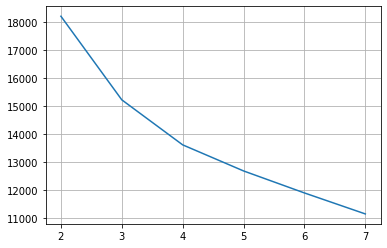

In [ ]:
plt.figure()
plt.plot(np.arange(2,8), nsclc_inertias)
plt.grid()
plt.show()

The elbow point seems to be around n=4. Explore the clusters:

In [11]:
n_cl_optimize = 4
my_kmeans = KMeans(n_clusters=n_cl_optimize, random_state=42)
my_kmeans.fit(X_tr_scaled)

collections.Counter(my_kmeans.labels_)

Counter({0: 78, 1: 106, 2: 73, 3: 37})

The number of points in each cluster seems reasonable. Proceed with the analysis:

In [ ]:
joblib.dump(my_kmeans, 'kmeans_4_test.pkl')

X_long = X_train.copy()
X_long['Cluster'] = my_kmeans.predict(X_tr_scaled)

X_long['Survival.time'] = y_train['Survival.time']
X_long['Deadstatus.event'] = y_train['deadstatus.event']

Make some Kaplan-Meier plots

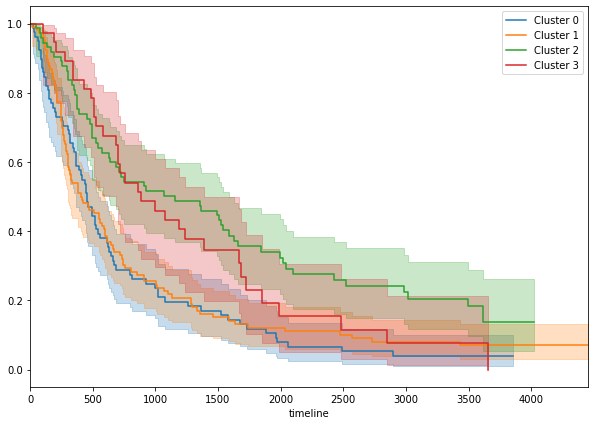

In [13]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,7))

for i in range(n_cl_optimize):
  kmf.fit(X_long[X_long['Cluster']==i]['Survival.time'], 
          X_long[X_long['Cluster']==i]['Deadstatus.event'], 
          label='Cluster '+str(i))

  if (i==0):
    ax1 = kmf.plot()
  else:
    kmf.plot(ax=ax1)

Cluster 1 and Cluster 0 seem to have survival curves very close to each other throughout the timeline. I will re-cluster the data into 3:

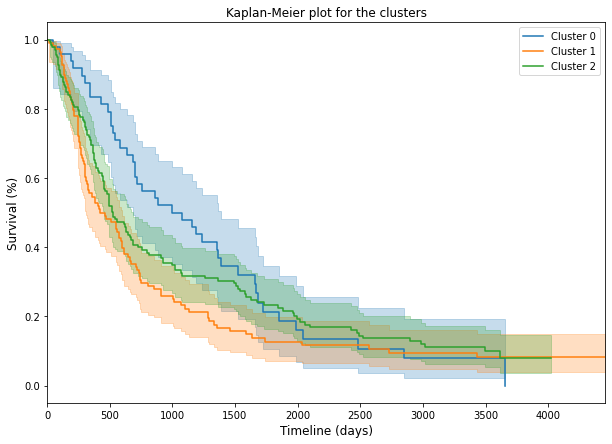

In [14]:
n_cl_optimize = 3
my_kmeans = KMeans(n_clusters=n_cl_optimize, random_state=42)
my_kmeans.fit(X_tr_scaled)

collections.Counter(my_kmeans.labels_)

joblib.dump(my_kmeans, 'kmeans_3.pkl')

X_long = X_train.copy()
X_long['Cluster'] = my_kmeans.predict(X_tr_scaled)

X_long['Survival.time'] = y_train['Survival.time']
X_long['Deadstatus.event'] = y_train['deadstatus.event']

plt.figure(figsize=(10,7))

median_list = []
ci_list = []

for i in range(n_cl_optimize):
  kmf.fit(X_long[X_long['Cluster']==i]['Survival.time'], 
          X_long[X_long['Cluster']==i]['Deadstatus.event'], 
          label='Cluster '+str(i))

  if (i==0):
    ax1 = kmf.plot()
    ax1.set_title('Kaplan-Meier plot for the clusters', fontsize=12)
    ax1.set_ylabel('Survival (%)', fontsize=12)
    ax1.set_xlabel('Timeline (days)', fontsize=12)
  else:
    kmf.plot(ax=ax1)
    ax1.set_xlabel('Timeline (days)', fontsize=12)

  median_list.append(kmf.median_survival_time_)
  ci_list.append(median_survival_times(kmf.confidence_interval_))

Clusters 0 and 1 seem to have some separation in their KM curves. We will explore the distributions according to all three clusters.

Number of data points per cluster:

In [ ]:
X_long['Cluster'].value_counts()

2    138
1    108
0     48
Name: Cluster, dtype: int64

##### Statistical significance of differences in survival at different points on timeline

In [ ]:
T1 = X_long[X_long['Cluster']==0]['Survival.time']
T2 = X_long[X_long['Cluster']==1]['Survival.time']

E1 = X_long[X_long['Cluster']==0]['Deadstatus.event']
E2 = X_long[X_long['Cluster']==1]['Deadstatus.event']

results_1yr = survival_difference_at_fixed_point_in_time_test(365, T1, T2, event_observed_A=E1, event_observed_B=E2)
results_1yr.print_summary()

So there is a statistically significant difference in the survival rates between two clusters at 1 year.

In [ ]:
results_3yr = survival_difference_at_fixed_point_in_time_test(3*365, T1, T2, event_observed_A=E1, event_observed_B=E2)
results_3yr.print_summary()

A statistically significant difference persists in the survival rates between the same two clusters at 3 years.

In [ ]:
results_5yr = survival_difference_at_fixed_point_in_time_test(5*365, T1, T2, event_observed_A=E1, event_observed_B=E2)
results_5yr.print_summary()

No statistically significant difference in the survival rates between the same two clusters at the 5-year mark.

##### Characteristics of the different clusters

What are the characteristics between the two clusters?

In [ ]:
data_1 = X_tr_scaled[X_long['Cluster']==0]
data_2 = X_tr_scaled[X_long['Cluster']==1]

ttest_results = ttest_ind(data_1, data_2, usevar='unequal')

In [ ]:
joblib.dump(ttest_results, 'kmeans_diff.pkl')

['kmeans_diff.pkl']

Storing the cluster data separately:

In [ ]:
df_data_1 = pd.DataFrame(data_1, columns=X.columns)
df_data_2 = pd.DataFrame(data_2, columns=X.columns)

In [ ]:
joblib.dump(df_data_1, 'df_cl1.pkl')
joblib.dump(df_data_2, 'df_cl2.pkl')

['df_cl2.pkl']

Storing the p-values in a dataframe with indices indicating the variables tested:

In [17]:
df_pval = pd.DataFrame(ttest_results[1], index=X.columns)
df_pval

,0
shape_Maximum3DDiameter_0,2.153122e-23
shape_MeshVolume_0,5.469580e-21
shape_MajorAxisLength_0,2.806385e-10
shape_Sphericity_0,2.740442e-11
shape_LeastAxisLength_0,6.837539e-40
...,...
log_glszm_SizeZoneNonUniformity_0,1.280538e-14
log_glszm_GrayLevelNonUniformity_0,1.289177e-27
log_glszm_ZonePercentage_0,5.169343e-59
log_glszm_LargeAreaLowGrayLevelEmphasis_0,4.611523e-47


In [ ]:
joblib.dump(df_pval, 'pvalues_variables.pkl')

['pvalues_variables.pkl']

Apply Holm-Bonferroni Correction to the thresholds:

In [ ]:
# No adding 1 in the denominator because of zero-indexing
df_pval['alpha'] = 0.05/(df_pval.shape[0] - np.array(ttest_results[1].argsort()))

In [ ]:
df_pval.columns = ['p values', 'alpha']

Compare the p-values with the respective thresholds:

In [ ]:
df_pval_sig = df_pval[df_pval['p values'] < df_pval['alpha']]

In [ ]:
df_pval_sig.shape

(78, 2)

All features that have statistically significant differences:

In [ ]:
df_pval_sig.index

Index(['shape_Maximum3DDiameter_0', 'shape_MeshVolume_0',
       'shape_MajorAxisLength_0', 'shape_Sphericity_0',
       'shape_LeastAxisLength_0', 'shape_SurfaceVolumeRatio_0',
       'shape_Maximum2DDiameterSlice_0', 'shape_SurfaceArea_0',
       'shape_MinorAxisLength_0', 'gldm_HighGrayLevelEmphasis_0',
       'gldm_DependenceEntropy_0', 'gldm_SmallDependenceEmphasis_0',
       'gldm_SmallDependenceHighGrayLevelEmphasis_0',
       'gldm_DependenceNonUniformityNormalized_0', 'gldm_DependenceVariance_0',
       'gldm_LargeDependenceHighGrayLevelEmphasis_0', 'glcm_JointEntropy_0',
       'glcm_ClusterShade_0', 'glcm_MaximumProbability_0', 'glcm_Idmn_0',
       'glcm_InverseVariance_0', 'glcm_Idm_0', 'glcm_Autocorrelation_0',
       'glcm_Imc2_0', 'glcm_Imc1_0', 'firstorder_InterquartileRange_0',
       'firstorder_Skewness_0', 'firstorder_Uniformity_0',
       'firstorder_Median_0', 'firstorder_Maximum_0',
       'firstorder_RootMeanSquared_0', 'firstorder_Entropy_0',
       'firstorde

Maybe just focus on the top 5:

In [21]:
p_ranks = ttest_results[1].argsort()
X.columns[p_ranks[0:5]]

Index(['glrlm_GrayLevelNonUniformityNormalized_0',
       'bc_firstorder_InterquartileRange_0', 'log_glszm_ZonePercentage_0',
       'log_firstorder_Kurtosis_0', 'bc_glszm_ZoneVariance_0'],
      dtype='object')

I will plot the histograms for the five features above. Cluster 0 has the highest 1-year survival, and will be denoted as "Higher survival". Similarly for the other clusters.

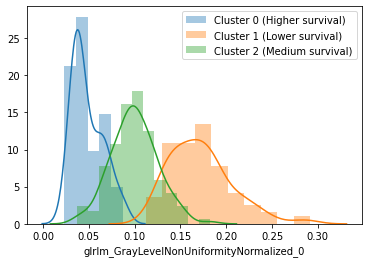

In [22]:
sns.distplot(X_long[X_long['Cluster']==0]['glrlm_GrayLevelNonUniformityNormalized_0'], label='Cluster 0 (Higher survival)')
sns.distplot(X_long[X_long['Cluster']==1]['glrlm_GrayLevelNonUniformityNormalized_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['glrlm_GrayLevelNonUniformityNormalized_0'], label='Cluster 2 (Medium survival)')
plt.legend()
plt.show()

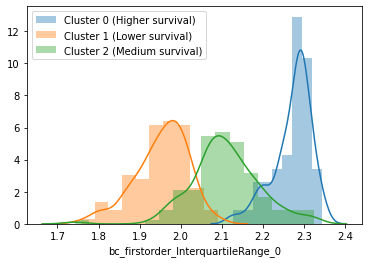

In [23]:
sns.distplot(X_long[X_long['Cluster']==0]['bc_firstorder_InterquartileRange_0'], label='Cluster 0 (Higher survival)')
sns.distplot(X_long[X_long['Cluster']==1]['bc_firstorder_InterquartileRange_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['bc_firstorder_InterquartileRange_0'], label='Cluster 2 (Medium survival)')
plt.legend()
plt.show()

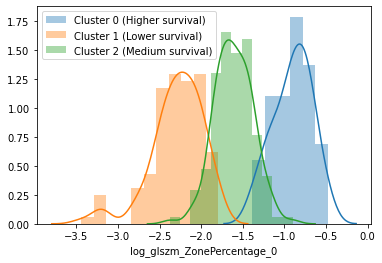

In [24]:
sns.distplot(X_long[X_long['Cluster']==0]['log_glszm_ZonePercentage_0'], label='Cluster 0 (Higher survival)')
sns.distplot(X_long[X_long['Cluster']==1]['log_glszm_ZonePercentage_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['log_glszm_ZonePercentage_0'], label='Cluster 2 (Medium survival)')
plt.legend()
plt.show()

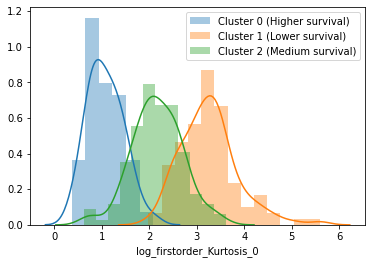

In [25]:
sns.distplot(X_long[X_long['Cluster']==0]['log_firstorder_Kurtosis_0'], label='Cluster 0 (Higher survival)')
sns.distplot(X_long[X_long['Cluster']==1]['log_firstorder_Kurtosis_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['log_firstorder_Kurtosis_0'], label='Cluster 2 (Medium survival)')
plt.legend()
plt.show()

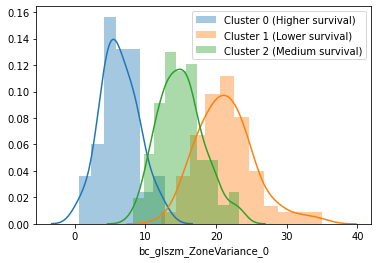

In [26]:
sns.distplot(X_long[X_long['Cluster']==0]['bc_glszm_ZoneVariance_0'], label='Cluster 0 (Higher survival)')
sns.distplot(X_long[X_long['Cluster']==1]['bc_glszm_ZoneVariance_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['bc_glszm_ZoneVariance_0'], label='Cluster 2 (Medium survival)')
plt.legend()
plt.show()

##### Median survival times for each cluster

In [27]:
for index, param in enumerate(median_list):
  print(f'Median survival time for Cluster {index}: {param}')
  print(f'Confidence interval on median survival for Cluster {index}: \n{ci_list[index]}\n')

Median survival time for Cluster 0: 1000.0
Confidence interval on median survival for Cluster 0: 
     Cluster 0_lower_0.95  Cluster 0_upper_0.95
0.5                 687.0                1391.0

Median survival time for Cluster 1: 423.0
Confidence interval on median survival for Cluster 1: 
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                 311.0                 597.0

Median survival time for Cluster 2: 524.0
Confidence interval on median survival for Cluster 2: 
     Cluster 2_lower_0.95  Cluster 2_upper_0.95
0.5                 456.0                 685.0



##### Check with test data
I will:
1. identify the cluster each data point in the test set belongs to;
2. fit a Kaplan-Meier curve through the test data points grouped by their cluster; and
3. compute the median survival time according to the Kaplan-Meier estimate for the three curves from the test data set
4. compare the test median survival times with the training median survival times

Define another dataframe containing cluster information for each entry in the test dataset, and append the survival time and event status (i.e. whether the patient has passed away):

In [ ]:
X_test_long = X_test.copy()
X_test_long['Cluster'] = my_kmeans.predict(X_tst_scaled)

X_test_long['Survival.time'] = y_test['Survival.time']
X_test_long['Deadstatus.event'] = y_test['deadstatus.event']

Now fit K-M survival curves through the test points grouped by clusters, and compute the respective median survival time and the confidence interval:

In [ ]:
median_test_list = []
ci_test_list = []

for i in range(n_cl_optimize):
  kmf.fit(X_test_long[X_test_long['Cluster']==i]['Survival.time'], 
          X_test_long[X_test_long['Cluster']==i]['Deadstatus.event'], 
          label='Cluster '+str(i))

  median_test_list.append(kmf.median_survival_time_)
  ci_test_list.append(median_survival_times(kmf.confidence_interval_))

What are the median survival times for the three clusters in the test data set?

In [30]:
for index, param in enumerate(median_test_list):
  print(f'Median survival time for Cluster {index}: {param}')
  print(f'Confidence interval on median survival for Cluster {index}: \n{ci_test_list[index]}\n')

Median survival time for Cluster 0: 673.0
Confidence interval on median survival for Cluster 0: 
     Cluster 0_lower_0.95  Cluster 0_upper_0.95
0.5                 426.0                1235.0

Median survival time for Cluster 1: 439.0
Confidence interval on median survival for Cluster 1: 
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                 195.0                 859.0

Median survival time for Cluster 2: 465.0
Confidence interval on median survival for Cluster 2: 
     Cluster 2_lower_0.95  Cluster 2_upper_0.95
0.5                 346.0                 715.0



The medians are no longer statistically significantly different. This is somewhat expected, as there are less data points in the test data points, and the statistical power will be less. However, there are two encouraging signs:

1. The medians for the three clusters follow the same pattern as for the training set, i.e. the median survival for Cluster 0 is highest, followed by Cluster 2, then Cluster 1;

2. The median survival time estimates all lie within the confidence intervals as given in the training dataset.

#### OPTICS

Try clustering with OPTICS:

In [ ]:
my_optics = OPTICS(min_samples=10, n_jobs=-1)
my_optics.fit(X_scaled)
joblib.dump(my_optics, 'optics.pkl')

['optics.pkl']

In [ ]:
X_long['OPTICS'].value_counts()

-1    408
 0     12
Name: OPTICS, dtype: int64

OPTICS does not work as well

### Combining K-Means with Decision Tree

#### 1-year analysis

I will try to repeat the analysis with the cluster from K-Means as an additional feature. I will choose one model to compare. Other models will only be run when a marked improvement is seen.

In [31]:
mask_1yrlong = (X_long['Deadstatus.event'] == 1) | (X_long['Survival.time'] > 365)
X_long.head()

,shape_Maximum3DDiameter_0,shape_MeshVolume_0,shape_MajorAxisLength_0,shape_Sphericity_0,shape_LeastAxisLength_0,shape_Elongation_0,shape_SurfaceVolumeRatio_0,shape_Maximum2DDiameterSlice_0,shape_Flatness_0,shape_SurfaceArea_0,shape_MinorAxisLength_0,gldm_HighGrayLevelEmphasis_0,gldm_DependenceEntropy_0,gldm_SmallDependenceEmphasis_0,gldm_SmallDependenceHighGrayLevelEmphasis_0,gldm_DependenceNonUniformityNormalized_0,gldm_DependenceVariance_0,gldm_LargeDependenceHighGrayLevelEmphasis_0,glcm_JointEntropy_0,glcm_ClusterShade_0,glcm_MaximumProbability_0,glcm_Idmn_0,glcm_InverseVariance_0,glcm_Idm_0,glcm_Correlation_0,glcm_Autocorrelation_0,glcm_MCC_0,glcm_Imc2_0,glcm_Imc1_0,firstorder_InterquartileRange_0,firstorder_Skewness_0,firstorder_Uniformity_0,firstorder_Median_0,firstorder_Energy_0,firstorder_Maximum_0,firstorder_RootMeanSquared_0,firstorder_90Percentile_0,firstorder_Minimum_0,firstorder_Entropy_0,firstorder_Range_0,...,glszm_SizeZoneNonUniformityNormalized_0,glszm_HighGrayLevelZoneEmphasis_0,glszm_ZoneEntropy_0,ngtdm_Coarseness_0,ngtdm_Complexity_0,ngtdm_Strength_0,ngtdm_Contrast_0,ngtdm_Busyness_0,log_shape_MeshVolume_0,log_gldm_GrayLevelVariance_0,log_gldm_DependenceNonUniformity_0,log_gldm_GrayLevelNonUniformity_0,bc_gldm_LargeDependenceLowGrayLevelEmphasis_0,bc_gldm_SmallDependenceLowGrayLevelEmphasis_0,bc_gldm_LowGrayLevelEmphasis_0,bc_glcm_JointEnergy_0,log_glcm_DifferenceVariance_0,log_glcm_SumSquares_0,bc_glcm_ClusterProminence_0,bc_glcm_DifferenceAverage_0,bc_firstorder_InterquartileRange_0,log_firstorder_Energy_0,log_firstorder_Kurtosis_0,log_firstorder_RootMeanSquared_0,log_glrlm_GrayLevelVariance_0,log_glrlm_RunVariance_0,log_glrlm_GrayLevelNonUniformity_0,log_glrlm_RunLengthNonUniformity_0,bc_glrlm_LongRunLowGrayLevelEmphasis_0,log_glszm_GrayLevelVariance_0,bc_glszm_ZoneVariance_0,log_glszm_GrayLevelNonUniformityNormalized_0,log_glszm_SizeZoneNonUniformity_0,log_glszm_GrayLevelNonUniformity_0,log_glszm_ZonePercentage_0,log_glszm_LargeAreaLowGrayLevelEmphasis_0,bc_glszm_LowGrayLevelZoneEmphasis_0,Cluster,Survival.time,Deadstatus.event
29,79.548648,46771.324419,66.243478,0.539864,33.029213,0.650248,0.248622,77.994957,0.498603,11628.387988,43.074694,1551.934085,7.051011,0.231761,258.071915,0.086874,24.730186,115081.320378,7.066659,-7372.047627,0.130207,0.986825,0.346197,0.421743,0.645068,1559.588437,0.689367,0.768594,-0.134396,129.0,-2.181319,0.129396,16.0,811412743.0,350.0,222.331229,56.0,-1024.0,3.928863,1374.0,...,0.502828,1081.317144,6.678812,0.000381,3368.707050,1.121584,0.125225,0.769183,10.753026,4.248907,7.262650,7.661074,-3.624385,-13.488270,-73.740736,-2.288238,3.452830,4.190825,35.225478,1.206894,2.162960,20.514287,2.012449,5.404168,4.374259,-0.720980,7.142699,9.143600,-52.299402,7.643202,14.885640,-3.436099,7.635615,4.887024,-1.382828,1.341403,-20.869037,2,999,1
140,149.873782,133095.145226,121.111204,0.408072,62.047949,0.679267,0.232110,116.718626,0.512322,30892.691814,82.266860,1126.320300,6.647593,0.125893,116.713579,0.063733,22.064525,94122.868812,5.448654,-390.214441,0.132906,0.998108,0.448000,0.530234,0.557400,1141.613373,0.593359,0.640641,-0.110144,50.0,-2.701132,0.179565,44.0,372284270.0,703.0,89.186783,80.0,-791.0,3.115362,1494.0,...,0.428461,890.619602,6.423494,0.000164,1700.774921,0.613861,0.009383,1.870508,11.798820,2.490167,8.000658,9.036484,-5.068585,-17.015531,-163.213247,-2.093221,1.558237,2.146834,19.157975,0.427987,1.993837,19.735168,2.708671,4.490733,2.707217,-0.498173,8.555053,10.006156,-104.054795,5.499626,19.968827,-2.904079,7.839886,5.783363,-2.066260,3.472288,-25.944037,1,4118,0
392,91.831399,11547.446251,115.045143,0.529093,20.092948,0.186026,0.404381,38.135985,0.174653,4669.562137,21.401331,571.319258,6.951992,0.176861,88.039948,0.098751,10.339175,21798.668538,6.738448,-265.896979,0.048921,0.994172,0.368768,0.400983,0.521140,579.850906,0.664808,0.725544,-0.146517,82.0,-1.215309,0.101880,-7.0,42658250.0,466.0,102.039550,73.0,-587.0,3.788172,1053.0,...,0.376547,487.979275,6.4

In [32]:
X_long_1yr = X_long[mask_1yrlong]
X_long_1yr.shape

(292, 90)

In [ ]:
X_dumcl_1yr = pd.get_dummies(X_long_1yr, columns=['Cluster'], drop_first=True)

In [ ]:
Xcl_train = X_dumcl_1yr.drop(columns=['Survival.time', 'Deadstatus.event'])
ycl_train = (X_dumcl_1yr['Survival.time'] > 365).astype(int)

In [ ]:
estimators = [('scale', StandardScaler()),
              ('PCA', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'PCA': [PCA()],
               'PCA__n_components': [x for x in range(5,num_feat,5)],
               'model': [DecisionTreeClassifier()],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid_cl = grid.fit(Xcl_train, ycl_train)

In [48]:
joblib.dump(fittedgrid_cl, 'dt_cluster_1yr.pkl')

['dt_cluster_1yr.pkl']

In [49]:
fittedgrid_cl.score(Xcl_train, ycl_train)

0.7157534246575342

In [50]:
X_test_long_1yr = X_test_long[(X_test_long['Deadstatus.event'] == 1) | 
                              (X_test_long['Survival.time'] > 365)]
X_test_long_1yr.head()

,shape_Maximum3DDiameter_0,shape_MeshVolume_0,shape_MajorAxisLength_0,shape_Sphericity_0,shape_LeastAxisLength_0,shape_Elongation_0,shape_SurfaceVolumeRatio_0,shape_Maximum2DDiameterSlice_0,shape_Flatness_0,shape_SurfaceArea_0,shape_MinorAxisLength_0,gldm_HighGrayLevelEmphasis_0,gldm_DependenceEntropy_0,gldm_SmallDependenceEmphasis_0,gldm_SmallDependenceHighGrayLevelEmphasis_0,gldm_DependenceNonUniformityNormalized_0,gldm_DependenceVariance_0,gldm_LargeDependenceHighGrayLevelEmphasis_0,glcm_JointEntropy_0,glcm_ClusterShade_0,glcm_MaximumProbability_0,glcm_Idmn_0,glcm_InverseVariance_0,glcm_Idm_0,glcm_Correlation_0,glcm_Autocorrelation_0,glcm_MCC_0,glcm_Imc2_0,glcm_Imc1_0,firstorder_InterquartileRange_0,firstorder_Skewness_0,firstorder_Uniformity_0,firstorder_Median_0,firstorder_Energy_0,firstorder_Maximum_0,firstorder_RootMeanSquared_0,firstorder_90Percentile_0,firstorder_Minimum_0,firstorder_Entropy_0,firstorder_Range_0,...,glszm_SizeZoneNonUniformityNormalized_0,glszm_HighGrayLevelZoneEmphasis_0,glszm_ZoneEntropy_0,ngtdm_Coarseness_0,ngtdm_Complexity_0,ngtdm_Strength_0,ngtdm_Contrast_0,ngtdm_Busyness_0,log_shape_MeshVolume_0,log_gldm_GrayLevelVariance_0,log_gldm_DependenceNonUniformity_0,log_gldm_GrayLevelNonUniformity_0,bc_gldm_LargeDependenceLowGrayLevelEmphasis_0,bc_gldm_SmallDependenceLowGrayLevelEmphasis_0,bc_gldm_LowGrayLevelEmphasis_0,bc_glcm_JointEnergy_0,log_glcm_DifferenceVariance_0,log_glcm_SumSquares_0,bc_glcm_ClusterProminence_0,bc_glcm_DifferenceAverage_0,bc_firstorder_InterquartileRange_0,log_firstorder_Energy_0,log_firstorder_Kurtosis_0,log_firstorder_RootMeanSquared_0,log_glrlm_GrayLevelVariance_0,log_glrlm_RunVariance_0,log_glrlm_GrayLevelNonUniformity_0,log_glrlm_RunLengthNonUniformity_0,bc_glrlm_LongRunLowGrayLevelEmphasis_0,log_glszm_GrayLevelVariance_0,bc_glszm_ZoneVariance_0,log_glszm_GrayLevelNonUniformityNormalized_0,log_glszm_SizeZoneNonUniformity_0,log_glszm_GrayLevelNonUniformity_0,log_glszm_ZonePercentage_0,log_glszm_LargeAreaLowGrayLevelEmphasis_0,bc_glszm_LowGrayLevelZoneEmphasis_0,Cluster,Survival.time,Deadstatus.event
145,163.450051,134594.321251,158.863703,0.539559,43.716117,0.387515,0.174892,81.588276,0.275180,23539.430388,61.562019,1639.993089,6.817623,0.171431,212.497975,0.079052,15.637072,96309.467958,6.456124,-3800.871364,0.081953,0.995280,0.408254,0.444673,0.634537,1659.963784,0.682937,0.698747,-0.110203,66.00,-2.956787,0.142184,14.0,1.308082e+09,679.0,166.521656,58.0,-1022.0,3.584753,1701.0,...,0.475234,1180.568497,6.767951,0.000152,3012.740488,0.591359,0.048964,1.675800,11.810021,3.738969,8.223930,8.810944,-6.699069,-13.893562,-114.475586,-2.316529,2.843590,3.534794,31.068941,0.890389,2.050075,20.991828,2.542719,5.115125,3.898488,-0.947990,8.419228,10.173980,-89.407084,7.655951,18.184908,-3.329839,8.278255,5.692363,-1.739375,2.494284,-19.380999,2,71,1
334,97.875165,40194.869041,81.826372,0.385875,29.688139,0.745330,0.365859,84.307382,0.362819,14705.649928,60.987659,1688.297130,6.785438,0.183945,239.712220,0.076476,18.472881,109190.437311,6.157343,-2764.937824,0.106531,0.991992,0.412086,0.479048,0.587804,1707.239434,0.616989,0.695929,-0.114296,62.00,-3.233198,0.150706,22.0,2.667291e+08,196.0,136.798716,65.0,-1020.0,3.439406,1216.0,...,0.523078,1266.775352,6.235589,0.000490,2222.688203,1.959175,0.041932,0.599987,10.601495,3.383214,6.993945,7.672301,-6.668600,-15.657554,-132.131223,-2.251363,2.749171,3.273568,29.583652,0.829196,2.037942,19.401744,2.767680,4.918511,3.553554,-0.824731,7.270103,8.952239,-100.127714,6.560380,14.208110,-3.066377,7.253723,4.835371,-1.662975,1.048778,-24.174173,2,3208,0
175,33.137314,1695.394516,27.959505,0.624267,8.071039,0.462708,0.649666,20.692988,0.288669,1101.439754,12.937098,857.290164,6.524652,0.518261,332.423946,0.272137,5.900124,17131.791803,7.986922,-4183.528750,0.043261,0.945743,0.195544,0.204538,0.363264,933.936629,0.595300,0.947676,-0.254882,430.25,-0.782544,0.045257,-128.5,6.987985e+07,145.0,338.462885,68.0,-870.0,4.908640,1015.0,...,0.605227,644

In [ ]:
X_test_dumcl_1yr = pd.get_dummies(X_test_long_1yr, columns=['Cluster'], drop_first=True)

In [ ]:
Xcl_test = X_test_dumcl_1yr.drop(columns=['Survival.time', 'Deadstatus.event'])
ycl_test = (X_test_dumcl_1yr['Survival.time'] > 365)

In [53]:
fittedgrid_cl.score(Xcl_test, ycl_test)

0.626984126984127

The test accuracy for the 1-year classification model is 62.70% - no improvement is seen.

Perhaps it is because the median survival times for all the clusters are all above 1 year, so the cluster can only be marginally useful, if at all.

To verify this claim, I will also repeat it for a model for 3-year survival.

#### 3-year analysis

In [ ]:
X_long_3yr = X_long[(X_long['Survival.time']>3*365)|
                    (X_long['Deadstatus.event']==1)]
X_dumcl_3yr = pd.get_dummies(X_long_3yr, columns=['Cluster'], drop_first=True)

In [ ]:
Xcl_3y_train = X_dumcl_3yr.drop(columns=['Survival.time', 'Deadstatus.event'])
ycl_3y_train = (X_dumcl_3yr['Survival.time'] > 3*365).astype(int)

In [ ]:
estimators = [('scale', StandardScaler()),
              ('PCA', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'PCA': [PCA()],
               'PCA__n_components': [x for x in range(5,num_feat,5)],
               'model': [DecisionTreeClassifier()],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid_cl = grid.fit(Xcl_3y_train, ycl_3y_train)

In [57]:
joblib.dump(fittedgrid_cl, 'dt_cluster_3yr.pkl')

['dt_cluster_3yr.pkl']

In [58]:
fittedgrid_cl.score(Xcl_3y_train, ycl_3y_train)

0.8321917808219178

Now score it with the test data:

In [ ]:
X_test_long_3yr = X_test_long[(X_test_long['Deadstatus.event'] == 1) | 
                              (X_test_long['Survival.time'] > 3*365)]

In [ ]:
X_test_dumcl_3yr = pd.get_dummies(X_test_long_3yr, columns=['Cluster'], drop_first=True)

In [ ]:
Xcl_3y_test = X_test_dumcl_3yr.drop(columns=['Survival.time', 'Deadstatus.event'])
ycl_3y_test = (X_test_dumcl_3yr['Survival.time'] > 3*365).astype(int)

In [62]:
fittedgrid_cl.score(Xcl_3y_test, ycl_3y_test)

0.6190476190476191

The accuracy score is 61.90%. We will stop here.